In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import impute
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import lightgbm as lgbm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, recall_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import unique_labels
import re
from scipy.special import boxcox1p

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Data Cleaning

In [4]:
target_col = ['Survived']

In [5]:
full_dataset = pd.concat([train.drop(target_col, axis=1), test])

In [6]:
obj_cols = full_dataset.select_dtypes(include='object').columns.tolist()

In [7]:
imp_median = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [8]:
num_cols = full_dataset.select_dtypes(include=['int64','float64']).columns.tolist()
for num_col in num_cols:
    if full_dataset[num_col].isnull().values.any():
        print('imputing for {}'.format(num_col))
        full_dataset[num_col] = imp_median.fit_transform(full_dataset[num_col].values.reshape(-1,1)) 

imputing for Age
imputing for Fare


In [9]:
full_dataset['Cabin'].fillna('None', inplace = True)

## Feature Engineering

In [10]:
def add_feature(df):
    #ticket length
    df['ticket_len'] = df['Ticket'].str.count(r'[a-zA-Z0-9 ]')
    
    #name honor
    df['Name_honor'] = [re.findall(r'[\w]+\.', item)[0] for item in df.Name.values.tolist()] 
    df['Name_honor'].loc[~df['Name_honor'].isin(['Mr.','Mrs.','Miss.', 'Master.'])] = 'Misc'
    
    #ticket category
    ticket_name = [item[0] for item in df.Ticket.str.split().tolist()] 
    ticket_name = [re.sub(r'\.', '', item) for item in ticket_name] 
    df['Ticket_cat'] = [item if re.findall(r'^[a-zA-Z]', item) else 'None' for item in ticket_name]
    
    #cabin count
    df['Cabin_count'] = [0 if type(item) == float else len(item) for item in df.Cabin.str.split(' ').values.tolist() ]
    
    #cabin category
    df['Cabin_category'] = ['None' if type(item) == float else list(set(re.findall(r'[a-zA-Z]', item)))[0] 
                           for item in df.Cabin.values.tolist()]
    
    #cabin number
    df['Cabin_number'] = [0 if type(item) == float else 
                             np.mean([int(num) for num in re.findall(r'[\d]+', item)]) 
                             for item in df.Cabin.values.tolist()]
    df['Cabin_number'].fillna(0, inplace = True)
    
    df['FamilySize'] = df ['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0
    
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels = False)
    df['AgeBin'] = pd.cut(df['Age'].astype(int), 5, labels = False)
    
    return df

In [11]:
full_dataset = add_feature(full_dataset)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Feature Scale

In [12]:
def skewness_check(df, num_cols):
    skew_cols = df[num_cols].skew().sort_values(ascending = False)
    skew_cols = skew_cols[abs(skew_cols) > 2].index.values.tolist()
    return skew_cols

In [13]:
skew_cols = skewness_check(full_dataset, num_cols)

### Log Transform

In [14]:
def log_transform(df, column):
    return np.log(df[column] + 1)

In [15]:
full_dataset_transformed = full_dataset.copy()
for skew_col in skew_cols:
    full_dataset_transformed[skew_col] = log_transform(full_dataset_transformed, skew_col)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e62be10>,
      dtype=object)

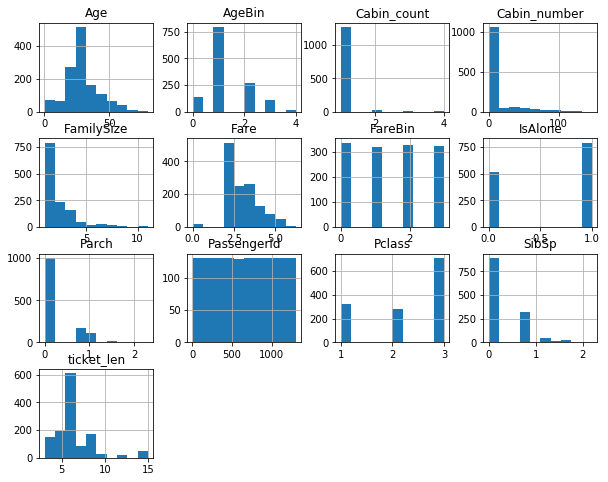

In [16]:
full_dataset_transformed.hist(figsize=(10,8))

## Train-Test Split and Feature Separation

In [17]:
cols_to_exclude = ['PassengerId','Survived','Ticket','Name','Cabin']

In [18]:
train_transformed = pd.merge(full_dataset, train, how = 'inner', on = ['PassengerId'], suffixes = ('','_y'))
test_transformed = pd.merge(full_dataset, test, how = 'inner', on = ['PassengerId'], suffixes = ('','_y'))

In [19]:
suffixes_col = [col for col in train_transformed.columns.values.tolist() if col.endswith('_y')]
train_transformed.drop(suffixes_col, axis=1, inplace = True)
test_transformed.drop(suffixes_col, axis=1, inplace = True)

In [20]:
feat_cols = [x for x in train_transformed.columns.values.tolist() if x not in cols_to_exclude]

In [21]:
features = pd.get_dummies(train_transformed[feat_cols])

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(features, train_transformed['Survived'], test_size=0.2, random_state=42)

### Feature Importances

In [23]:
scale_pos_weight_val = train_transformed['Survived'].value_counts()[0]//train_transformed['Survived'].value_counts()[1]

In [24]:
model = lgbm.LGBMClassifier(objective ='binary',
    learning_rate = 0.01,
    num_leaves = 76,
    n_estimators = 1000,
    feature_fraction= 0.64, 
    bagging_fraction= 0.8, 
    bagging_freq=1,
    boosting_type = 'gbdt',
    metric= 'binary_logloss',
    scale_pos_weight = scale_pos_weight_val,
    silent = True,
    n_jobs = -1)

In [25]:
model.fit(X_train, y_train, 
          eval_metric = ['auc', 'binary_logloss'],
          eval_set = [(X_valid, y_valid)],
          early_stopping_rounds = 500, 
          verbose = True)

[1]	valid_0's auc: 0.867439	valid_0's binary_logloss: 0.676217
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.85888	valid_0's binary_logloss: 0.671894
[3]	valid_0's auc: 0.852381	valid_0's binary_logloss: 0.667483
[4]	valid_0's auc: 0.855341	valid_0's binary_logloss: 0.663197
[5]	valid_0's auc: 0.855663	valid_0's binary_logloss: 0.659587
[6]	valid_0's auc: 0.858623	valid_0's binary_logloss: 0.655445
[7]	valid_0's auc: 0.861454	valid_0's binary_logloss: 0.651009
[8]	valid_0's auc: 0.868018	valid_0's binary_logloss: 0.646795
[9]	valid_0's auc: 0.867954	valid_0's binary_logloss: 0.642865
[10]	valid_0's auc: 0.873102	valid_0's binary_logloss: 0.638603
[11]	valid_0's auc: 0.870978	valid_0's binary_logloss: 0.634827
[12]	valid_0's auc: 0.876448	valid_0's binary_logloss: 0.631408
[13]	valid_0's auc: 0.879408	valid_0's binary_logloss: 0.627497
[14]	valid_0's auc: 0.877284	valid_0's binary_logloss: 0.623882
[15]	valid_0's auc: 0.878507	valid_0's binary_loglos

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=76, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

feature_imp['cum_pct'] = feature_imp['Value'].cumsum()/feature_imp['Value'].sum()

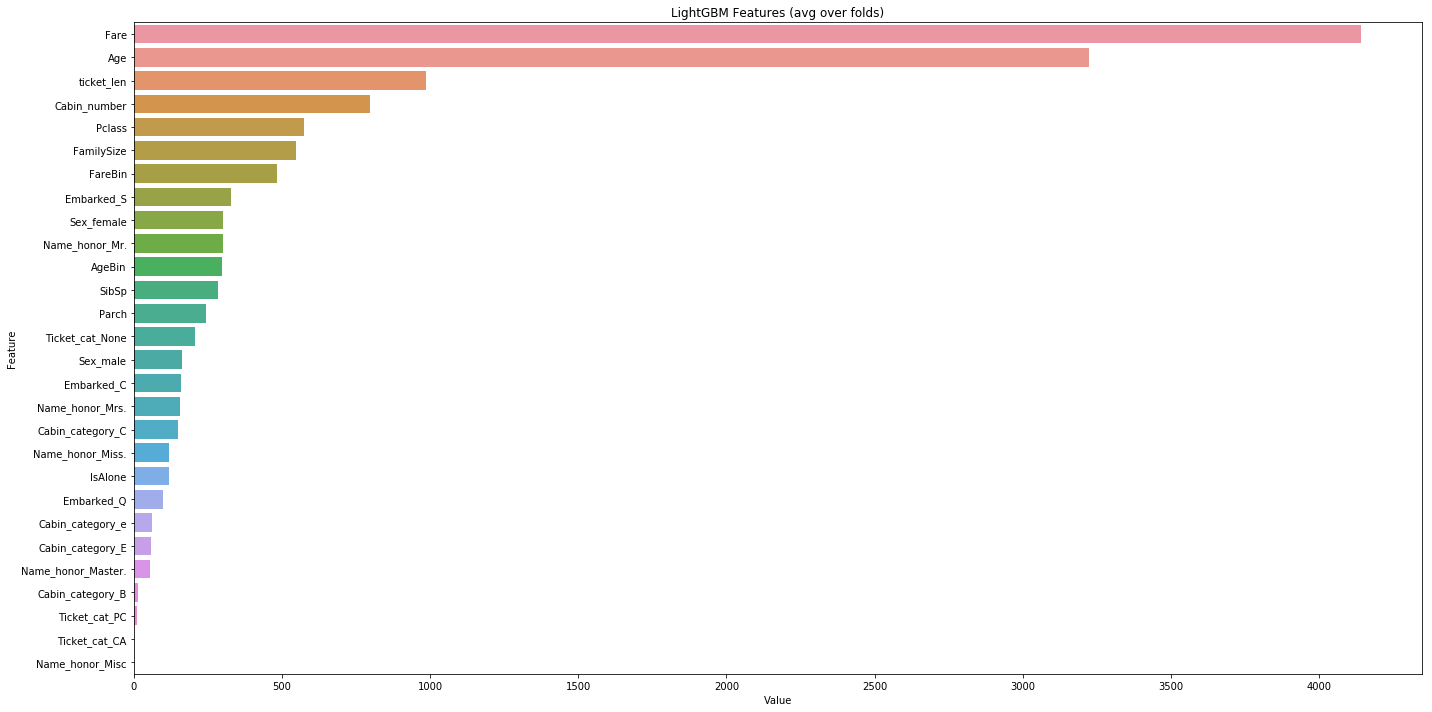

In [27]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.loc[feature_imp['Value'] > 0].sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [28]:
top_feats = feature_imp.loc[feature_imp['Value'] > 0].Feature.values.tolist()

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(features[top_feats], train_transformed['Survived'], test_size=0.2, random_state=42)

## Model Benchmarking

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [31]:
class_names = train.Survived.unique()

### Logistic

In [32]:
lr = LogisticRegression(solver='lbfgs',
                       multi_class = 'ovr',
                       n_jobs = -1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

AUC Score: 0.877429
Recall Score: 0.750000
F1 Score: 0.780583


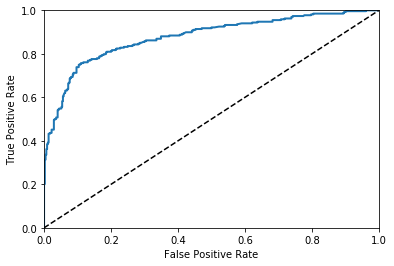

In [33]:
print("AUC Score: %f" % roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
print("Recall Score: %f" %recall_score(y_train, lr.predict(X_train)))
print("F1 Score: %f" % f1_score(y_train, lr.predict(X_train)))
fpr, tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
plot_roc_curve(fpr, tpr)
plt.show()

Confusion matrix, without normalization
[[398  46]
 [ 67 201]]
Normalized confusion matrix
[[0.8963964 0.1036036]
 [0.25      0.75     ]]


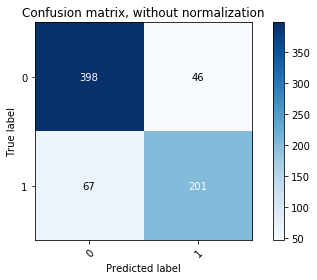

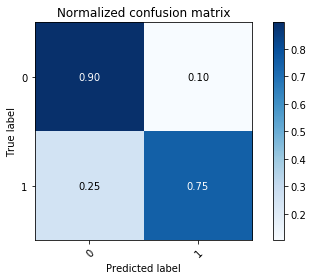

In [34]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, lr.predict(X_train), classes=class_names, 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train, lr.predict(X_train), classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Random Forest

In [35]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [36]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

AUC Score: 0.861007
Recall Score: 0.675373
F1 Score: 0.725451


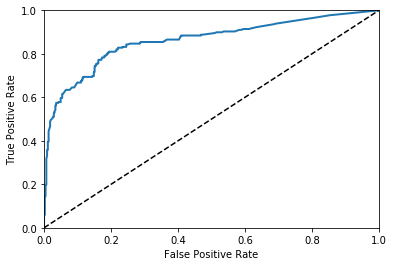

In [37]:
print("AUC Score: %f" % roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1]))
print("Recall Score: %f" %recall_score(y_train, rfc.predict(X_train)))
print("F1 Score: %f" % f1_score(y_train, rfc.predict(X_train)))
fpr, tpr, thresholds = roc_curve(y_train, rfc.predict_proba(X_train)[:,1])
plot_roc_curve(fpr, tpr)
plt.show()

Confusion matrix, without normalization
[[394  50]
 [ 87 181]]
Normalized confusion matrix
[[0.88738739 0.11261261]
 [0.32462687 0.67537313]]


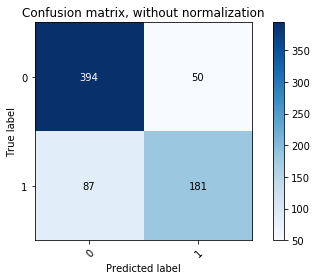

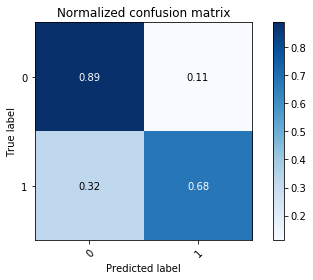

In [38]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, rfc.predict(X_train), classes=class_names, 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train, rfc.predict(X_train), classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### XGBoost

In [39]:
xgbc = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     n_jobs = -1,
     scale_pos_weight=scale_pos_weight_val,
     silent = True,
     seed=27)

In [40]:
xgbc.fit(X_train, y_train, 
         eval_metric = 'auc',
         eval_set = [(X_valid, y_valid)],
         early_stopping_rounds = 500)

[0]	validation_0-auc:0.830245
Will train until validation_0-auc hasn't improved in 500 rounds.
[1]	validation_0-auc:0.852188
[2]	validation_0-auc:0.867503
[3]	validation_0-auc:0.865058
[4]	validation_0-auc:0.860103
[5]	validation_0-auc:0.857593
[6]	validation_0-auc:0.85547
[7]	validation_0-auc:0.853024
[8]	validation_0-auc:0.851416
[9]	validation_0-auc:0.86242
[10]	validation_0-auc:0.867954
[11]	validation_0-auc:0.863449
[12]	validation_0-auc:0.868275
[13]	validation_0-auc:0.865573
[14]	validation_0-auc:0.864286
[15]	validation_0-auc:0.863642
[16]	validation_0-auc:0.867503
[17]	validation_0-auc:0.867246
[18]	validation_0-auc:0.868211
[19]	validation_0-auc:0.865766
[20]	validation_0-auc:0.869112
[21]	validation_0-auc:0.867439
[22]	validation_0-auc:0.862548
[23]	validation_0-auc:0.861776
[24]	validation_0-auc:0.863192
[25]	validation_0-auc:0.866345
[26]	validation_0-auc:0.866281
[27]	validation_0-auc:0.866924
[28]	validation_0-auc:0.865637
[29]	validation_0-auc:0.866281
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8, verbosity=1)

AUC Score: 0.986516
Recall Score: 0.891791
F1 Score: 0.926357


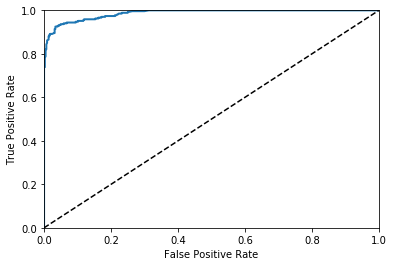

In [41]:
print("AUC Score: %f" % roc_auc_score(y_train, xgbc.predict_proba(X_train)[:,1]))
print("Recall Score: %f" %recall_score(y_train, xgbc.predict(X_train)))
print("F1 Score: %f" % f1_score(y_train, xgbc.predict(X_train)))
fpr, tpr, thresholds = roc_curve(y_train, xgbc.predict_proba(X_train)[:,1])
plot_roc_curve(fpr, tpr)
plt.show()

Confusion matrix, without normalization
[[435   9]
 [ 29 239]]
Normalized confusion matrix
[[0.97972973 0.02027027]
 [0.10820896 0.89179104]]


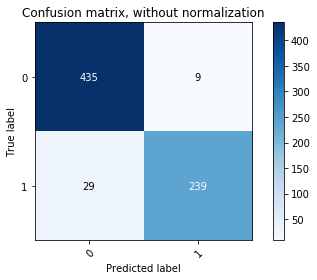

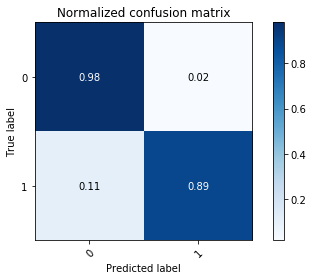

In [42]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, xgbc.predict(X_train), classes=class_names, 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train, xgbc.predict(X_train), classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Comparison

In [43]:
def cross_validate(model, features, label, n_cv, scoring):
    scores = cross_val_score(model, features, label,
                             scoring=scoring, cv=n_cv)
    
    return scores

In [44]:
def model_benchmark(models, X_test, y_test, n_cv, scoring):
    performance_benchmark = pd.DataFrame(columns=['model',scoring])
    for model in models:
        temp_model = [model]*n_cv
        temp_performance = cross_validate(models[model], X_test, y_test, n_cv, scoring)
        temp_df = pd.DataFrame({'model': temp_model, scoring: temp_performance})
        performance_benchmark = pd.merge(performance_benchmark, temp_df, how = 'outer')
    sns.boxplot(x="model", y=scoring, data=performance_benchmark)
    plt.title('Performance Benchmark')

In [45]:
models = {'logistic' : lr, 'random forest': rfc, 'xgboost': xgbc}

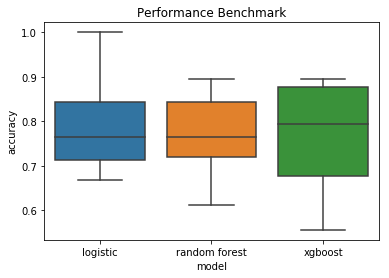

In [46]:
model_benchmark(models, X_valid, y_valid, 10, 'accuracy')

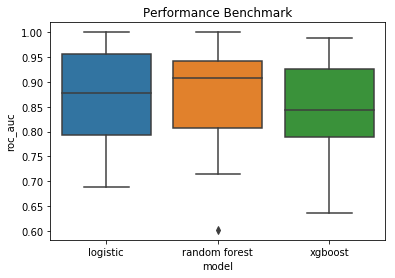

In [47]:
model_benchmark(models, X_valid, y_valid, 10, 'roc_auc')

## Export Model

In [48]:
import joblib

In [49]:
joblib.dump(lr, 'logisticreg.pkl')
joblib.dump(rfc, 'randomforestclassifier.pkl')
joblib.dump(xgbc, 'xgbclassifier.pkl')

['xgbclassifier.pkl']

## Test

In [50]:
def predict_export_csv(model, feature, index, file_name):
    temp_output = model.predict(feature)
    temp_output_df = pd.DataFrame({'PassengerId': index, 'Survived': temp_output })
    temp_output_df.to_csv('{}.csv'.format(file_name), sep=',', encoding='utf-8', index=False)

In [51]:
test_processed_features = pd.get_dummies(test_transformed)

In [52]:
test_processed_features = test_processed_features[top_feats]

In [53]:
predict_export_csv(xgbc, test_processed_features, test['PassengerId'], 'xgb_classifier1')

In [54]:
predict_export_csv(lr, test_processed_features, test['PassengerId'], 'lr_classifier1')

In [55]:
predict_export_csv(rfc, test_processed_features, test['PassengerId'], 'rfc_classifier1')